In [1]:
# MNIST dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

# loader
from torch.utils.data import DataLoader

# neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# plotting
import matplotlib.pyplot as plt

# numpy
import numpy as np

In [78]:
# Loading data
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = False
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = False
)

In [79]:
loaders = {
    'train': DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    'test': DataLoader(test_data, batch_size=100, shuffle=False, num_workers=1)
}

In [80]:
# Define model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.softmax(x, dim=1)


In [81]:
# Instantiate and define training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()   # put model in training mode
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()   # initialize with 0
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loaders['train'].dataset),
                100. * batch_idx / len(loaders['train']), loss.item()))

def test():
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(loaders['test'].dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f}%)\n')
    return test_loss

In [82]:
# train
def train_with_early_stopping(epochs, patience=5):
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, epochs + 1):
        train(epoch)
        test_loss = test()

        if test_loss < best_loss:
            best_loss = test_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), '../models/best_CNN_model.pth')
        else:
            patience_counter += 1
            print(f'Validation loss did not improve. Patience: {patience_counter}/{patience}')

            if patience_counter >= patience:
                print('Early stopping triggered!')
                break

train_with_early_stopping(epochs=100, patience=5)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301508
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.291820
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.173026
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.016943
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.913834
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.829470
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.877075
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.764045
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.755859
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.796059
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.761924
Train Epoch: 1 [22000/60000 (37%)]	Loss: 1.848905
Train Epoch: 1 [24000/60000 (40%)]	Loss: 1.806953
Train Epoch: 1 [26000/60000 (43%)]	Loss: 1.727366
Train Epoch: 1 [28000/60000 (47%)]	Loss: 1.711292
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.697193
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.683321
Train Epoch: 1 [34000/60000 (57%)]	Loss: 1.604649
Train Epoch: 1 [36000/60000 (60%)]	Loss: 1.654587
Train Epoch: 1 [38000/60000 (63%)]	Loss: 1.639139
Train Epoch

Prediction: 0


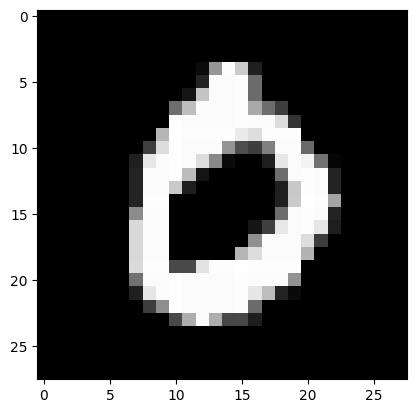

In [83]:
# test
model.eval()

data, target = test_data[3]

data = data.unsqueeze(0).to(device)

output = model(data)

prediction = output.argmax(dim=1, keepdim=True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()

In [84]:
# save model
torch.save(model.state_dict(), '../models/CNN_model.pth')

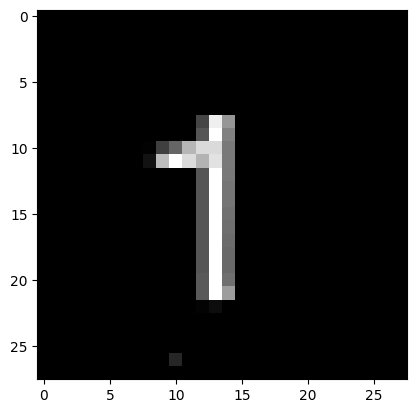

In [113]:
my_number = []
with open('../data/personal/number.txt', 'r') as f:
    for line in f:
        my_number.append([int(nr) for nr in line.split()])
my_number_np = np.array(my_number)
plt.imshow(my_number_np, cmap='gray')
plt.show()
my_number = [[x / 255 for x in row] for row in my_number]

In [114]:
tensor_img = torch.tensor(my_number).reshape(1, 1, 28, 28)
pred = model(tensor_img)
print(f"Prediction: {pred.argmax().item()} with probability {pred.max().item()}")

Prediction: 1 with probability 0.9972400665283203
